# Simple Paper-Based Game

## Title

**Echo Runner – Solo Dice Adventure**

## Description (1–2 sentences)

Travel the path to the treasure cave. Avoid traps and use events to your advantage before running out of hearts.

## Components

1 player, 2 six-sided dice (or simulator). 3 starting hearts.

## Setup

Draw a path of **30 spaces** numbered from **Start (1)** to **Goal (30)**. Mark **Event Spaces**: 5, 9, 12, 15, 18, 22, 25.

## Game Turn

1. **Movement:** Roll **1d6** and advance that number of spaces.
2. If you land on **Event Space**, roll **2d6** and apply the **Event Table**.

## Event Table (roll 2d6)

* **2–3**: Trap — lose **1 heart**.
* **4–5**: Panic — **Back 2** spaces.
* **6–8**: Nothing — Take a breath, nothing happens.
* **9–10**: Pace — **Advance 2** spaces.
* **11**: Medkit — **+1 heart** (max 4).
* **12**: Sprint — roll 1d6 and **advance** that number.

## Skill Rule (choice at forks)

Draw **two branches** between spaces 16→20:

* **Short Path (risky):** Skip one event space, but **-1 on your next movement roll**.
* **Long Path (safe):** No penalty, but +2 spaces total.

## Ending Conditions

* **You win** when you enter the **30 (Goal)** space with at least 1 heart.
* **You lose** if you drop to **0 hearts** at any time.

## Balance Tips

* Too easy? Start with **2 hearts** or add an extra event space.
* Too difficult? Allow **1 reroll** per game on a movement or event roll.

---

Single play result: win | turns: 12 | final hearts: 3
Board image: \mnt\data\echo_runner_outputs\echo_runner_board_sample.png
Board PDF: \mnt\data\echo_runner_outputs\echo_runner_board_sample.pdf
Event histogram: \mnt\data\echo_runner_outputs\echo_runner_event_hist.png


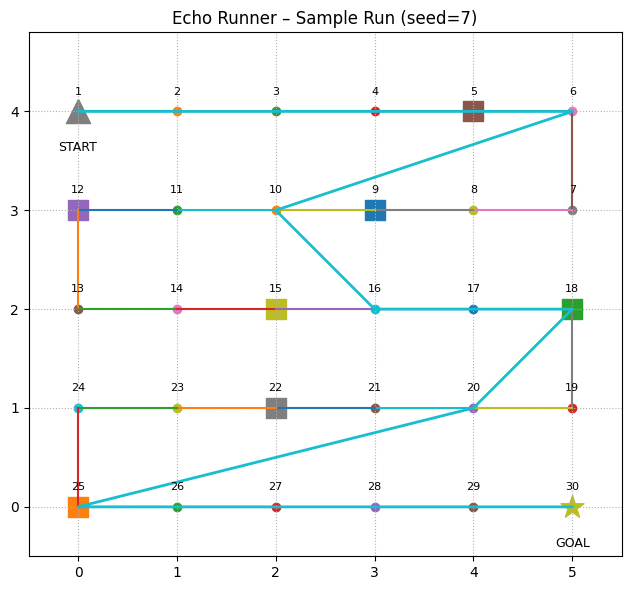

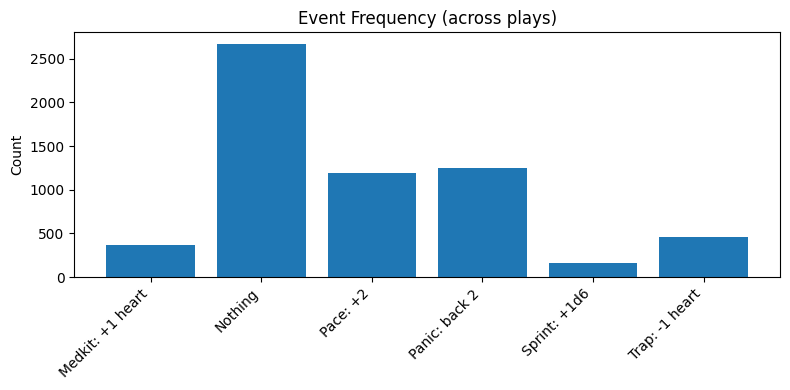

In [2]:
# %%
# Echo Runner – Solo Dice Adventure (fixed)
import math
import random
from dataclasses import dataclass, replace
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------------
# Game configuration
# -----------------------------
N_SPACES = 30
EVENT_SPACES = {5, 9, 12, 15, 18, 22, 25}
MAX_HEARTS = 4
START_HEARTS = 3

# Branch between 16 -> 20
BRANCH_START = 16
BRANCH_END = 20

# Event table (2d6)
def event_effect(roll_2d6: int):
    if roll_2d6 in (2, 3):
        return ("Trap: -1 heart", lambda state: replace(state, hearts=max(0, state.hearts-1)))
    elif roll_2d6 in (4, 5):
        return ("Panic: back 2", lambda state: replace(state, pos=max(1, state.pos-2)))
    elif 6 <= roll_2d6 <= 8:
        return ("Nothing", lambda state: state)
    elif roll_2d6 in (9, 10):
        return ("Pace: +2", lambda state: replace(state, pos=min(N_SPACES, state.pos+2)))
    elif roll_2d6 == 11:
        return ("Medkit: +1 heart", lambda state: replace(state, hearts=min(MAX_HEARTS, state.hearts+1)))
    else:  # 12
        return ("Sprint: +1d6", lambda state: replace(state, pos=min(N_SPACES, state.pos+random.randint(1,6))))

@dataclass(frozen=True)
class State:
    pos: int
    hearts: int
    next_move_penalty: int = 0  # for Short Path penalty (-1 next movement)

# Policy at the branch: choose Short if hearts >= 2, else Long
def choose_branch(hearts: int) -> str:
    return "short" if hearts >= 2 else "long"

def step(state: State) -> Tuple[State, Dict]:
    """Play one turn and return (new_state, log)."""
    move_roll = random.randint(1, 6)
    effective_move = max(1, move_roll - state.next_move_penalty)
    new_pos = min(N_SPACES, state.pos + effective_move)
    new_state = replace(state, pos=new_pos, next_move_penalty=0)  # penalty consumed
    
    logs = {
        "move_roll": move_roll,
        "effective_move": effective_move,
        "pre_event_pos": new_pos,
        "event": None,
        "event_roll": None,
        "branch_choice": None,
    }
    
    # Branch handling
    if BRANCH_START <= new_state.pos < BRANCH_END:
        choice = choose_branch(new_state.hearts)
        logs["branch_choice"] = choice
        if choice == "short":
            # apply -1 next movement penalty
            new_state = replace(new_state, next_move_penalty=1)
        else:
            # Long path: +2 spaces total
            new_state = replace(new_state, pos=min(N_SPACES, new_state.pos + 2))
    
    # Event check
    if new_state.pos in EVENT_SPACES:
        r2 = random.randint(1, 6) + random.randint(1, 6)
        label, fx = event_effect(r2)
        new_state = fx(new_state)
        logs["event"] = label
        logs["event_roll"] = r2
    
    return new_state, logs

def play_once(seed=None, max_turns=500):
    if seed is not None:
        random.seed(seed)
    state = State(pos=1, hearts=START_HEARTS, next_move_penalty=0)
    history = []
    for turn in range(1, max_turns+1):
        if state.hearts <= 0:
            return {"result": "lose", "turns": turn-1, "final_pos": state.pos, "final_hearts": state.hearts, "history": history}
        if state.pos >= N_SPACES:
            return {"result": "win", "turns": turn-1, "final_pos": state.pos, "final_hearts": state.hearts, "history": history}
        state, logs = step(state)
        logs.update({"turn": turn, "pos": state.pos, "hearts": state.hearts})
        history.append(logs)
    return {"result": "timeout", "turns": max_turns, "final_pos": state.pos, "final_hearts": state.hearts, "history": history}

def simulate(n=5000, seed=42):
    random.seed(seed)
    results = []
    turns = []
    for _ in range(n):
        out = play_once()
        results.append(out["result"])
        turns.append(out["turns"])
    win_rate = results.count("win") / n
    lose_rate = results.count("lose") / n
    timeout_rate = results.count("timeout") / n
    avg_turns = sum(turns)/n
    return {
        "n": n,
        "win_rate": win_rate,
        "lose_rate": lose_rate,
        "timeout_rate": timeout_rate,
        "avg_turns": avg_turns
    }

# -----------------------------
# Board layout (serpentine 6x5 grid)
# -----------------------------
cols, rows = 6, 5
coords = {}
k = 1
for r in range(rows):
    row_indices = range(cols) if r % 2 == 0 else range(cols-1, -1, -1)
    for c in row_indices:
        x = c
        y = rows - 1 - r
        coords[k] = (x, y)
        k += 1

def draw_board(path=None, title="Echo Runner – Board"):
    fig, ax = plt.subplots(figsize=(8, 6))
    for k in range(1, N_SPACES+1):
        x, y = coords[k]
        ax.scatter([x], [y])
        ax.text(x, y+0.15, str(k), ha="center", va="bottom", fontsize=8)
        if k < N_SPACES:
            x2, y2 = coords[k+1]
            ax.plot([x, x2], [y, y2])
        if k in EVENT_SPACES:
            ax.scatter([x], [y], s=200, marker="s")
    xs, ys = coords[1]
    xg, yg = coords[N_SPACES]
    ax.scatter([xs], [ys], s=300, marker="^")
    ax.text(xs, ys-0.3, "START", ha="center", va="top", fontsize=9)
    ax.scatter([xg], [yg], s=300, marker="*")
    ax.text(xg, yg-0.3, "GOAL", ha="center", va="top", fontsize=9)
    if path:
        px = [coords[p][0] for p in path]
        py = [coords[p][1] for p in path]
        ax.plot(px, py, linewidth=2)
    ax.set_title(title)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xlim(-0.5, cols-0.5)
    ax.set_ylim(-0.5, rows-0.2)
    ax.set_aspect("equal")
    ax.grid(True, linestyle=":")
    fig.tight_layout()
    return fig, ax

# -----------------------------
# Single play demo
# -----------------------------
demo = play_once(seed=7)
demo_path = [1] + [h["pos"] for h in demo["history"]]
fig1, ax1 = draw_board(path=demo_path, title="Echo Runner – Sample Run (seed=7)")

# Save images for print
out_dir = Path("/mnt/data/echo_runner_outputs")
out_dir.mkdir(parents=True, exist_ok=True)
png_path = out_dir / "echo_runner_board_sample.png"
pdf_path = out_dir / "echo_runner_board_sample.pdf"
fig1.savefig(png_path, dpi=200)
fig1.savefig(pdf_path)

# -----------------------------
# Monte Carlo
# -----------------------------
stats = simulate(n=3000, seed=123)
df_stats = pd.DataFrame([stats])

# from caas_jupyter_tools import display_dataframe_to_user
# display_dataframe_to_user("Echo Runner – Simulation Summary", df_stats)

df_stats

# -----------------------------
# Event histogram
# -----------------------------
def collect_event_labels(n=3000, seed=99):
    random.seed(seed)
    labels = []
    for _ in range(n):
        result = play_once()
        for h in result["history"]:
            if h["event"]:
                labels.append(h["event"])
    return labels

labels = collect_event_labels()
unique, counts = np.unique(labels, return_counts=True)

fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.bar(unique, counts)
ax2.set_title("Event Frequency (across plays)")
ax2.set_ylabel("Count")
ax2.set_xticks(range(len(unique)))
ax2.set_xticklabels(unique, rotation=45, ha="right")
fig2.tight_layout()

# Save histogram
hist_path = out_dir / "echo_runner_event_hist.png"
fig2.savefig(hist_path, dpi=200)

print("Single play result:", demo["result"], "| turns:", demo["turns"], "| final hearts:", demo["final_hearts"])
print("Board image:", png_path)
print("Board PDF:", pdf_path)
print("Event histogram:", hist_path)
